Before running the code blocks, run the following commands to get the kernel prepared:
```sh
julia
import Pkg
Pkg.update()
Pkg.precompile()

using Pkg
Pkg.build("IJulia")
```

In [236]:
using HDF5
using Serialization
using DataFrames, Plots, Statistics
using Plots.PlotMeasures 
using DataFramesMeta
using Missings

In [237]:
has_data(v) = any(!ismissing, v)
safe_mean(v) = has_data(v) ? mean(skipmissing(v)) : missing
safe_std(v)  = has_data(v) ? std(skipmissing(v); corrected=false) : missing
safe_min(v)  = has_data(v) ? minimum(skipmissing(v)) : missing
safe_max(v)  = has_data(v) ? maximum(skipmissing(v)) : missing


safe_max (generic function with 1 method)

In [ ]:

function timer_dict_to_df(timer_dict, optimization, flatten=false)
    rows = []

    for (trial, ranks) in timer_dict
        k, total_rank, nprt_per_rank, n_float_per_particle, perm, p = split(trial, ":")
        k = k == "half" ? "50%" : k
        trial_name = "$k($p) particles"
        for (rank, timers) in ranks
            function format_row(op, metric, value)
                return (
                    optimization = optimization,
                    trial  = String(trial_name),
                    perm = String(perm),
                    total_rank = parse(Int, total_rank),
                    particle_size = n_float_per_particle,
                    nprt_per_rank = nprt_per_rank,
                    rank   = string(rank),
                    op     = String(op),
                    metric = String(metric),
                    value  = value,
                )
            end
            function recursive_push(inner_timers)
                for (op, metrics) in inner_timers
                    if op == "receive loop" && flatten
                        for (inner_op, inner_metrics) in metrics["inner_timers"]
                            for (metric, value) in inner_metrics
                                push!(rows, format_row(inner_op, metric, value))
                            end
                        end
                    else
                        push!(rows, format_row(op, "time_ns", metrics["time_ns"]))
                        push!(rows, format_row(op, "n_calls", metrics["n_calls"]))
                        recursive_push(metrics["inner_timers"])
                    end
                end
            end
            push!(rows, format_row("overall", "time_ns", timers["time_ns"]))
            push!(rows, format_row("overall", "n_calls", timers["n_calls"]))
            recursive_push(timers["inner_timers"])
        end
    end
    return DataFrame(rows)
end

timer_dict_to_df (generic function with 2 methods)

In [218]:
function render(df, label=false)
  trials = unique(df.trial)
  ops    = unique(df.op)

  ntrials, nops = length(trials), length(ops)

  # 2) Create an empty grid, with row & column titles
  plt = plot(
    layout     = (ntrials, nops),
    legend = label ? :topleft : :none,
    size       = (300 * nops, 300 * ntrials),
  )

  # 3) Fill it in
  for (i, trial) in enumerate(trials)
    for (j, op) in enumerate(ops)
      sub = df[(df.trial .== trial) .& (df.op .== op), :]
      for rk in unique(sub.rank)
        subrk = sub[sub.rank .== rk, :]
        scatter!(
          plt[i, j],
          string.(subrk.total_rank),    # categorical x
          subrk.time_ms;
          marker     = :circle,
          markersize = 4,
          label      = rk,
          right_margin = 10mm,
          color      = rk == "0" ? :blue : :orange,
        )
      end
      plot!(plt[i, j], title = string(op), top_margin = 10mm)
      if j == 1
        plot!(plt[i, j], ylabel = string(trial), left_margin = 20mm)
      end

      # only the bottom row gets the shared x‐axis label
      if i == ntrials
        plot!(plt[i, j], xlabel = "Total Rank")
      end
    end
  end

  display(plt)
  return plt
end

render (generic function with 2 methods)

In [219]:
function df_from_h5(root_dir, category)
    optimization = split(category, "/")[end]

    root = dirname(@__FILE__)
    h5path(rank) = joinpath(root, "../$(root_dir)/$(category)/", "all_timers_$(rank).h5") 
    all_timer_dfs = DataFrame()
    for rank in [2, 4, 8, 16, 32]
        blob = h5open(h5path(rank)) do f
            read(f, "all_timers")
        end

        # Deserialize back into Dict{String,Dict{Int,Dict{String,Any}}}
        merged_timers = deserialize(IOBuffer(blob))

        # Convert to DataFrame
        timer_df = timer_dict_to_df(merged_timers, optimization)
        
        # Concat to all_timer_dfs
        all_timer_dfs = vcat(all_timer_dfs, timer_df)
    end

    wide = unstack(
    all_timer_dfs,
    [:optimization, :trial, :perm, :total_rank, :nprt_per_rank, :particle_size, :rank, :op],
    :metric,
    :value
    )

    # Compute the average time per call
    wide.time_ns .= wide.time_ns ./ wide.n_calls
    # Sort by perm and trial
    wide = sort!(wide, [:perm, :trial])

    first_df = wide[wide.perm .== "firstperm", :]
    rand_df = wide[wide.perm .== "randperm", :]
    return (first_df, rand_df)
end

df_from_h5 (generic function with 2 methods)

In [220]:

function widen_ops(df::DataFrame)
    rename!(df, Symbol.(names(df)))

    keys   = [:optimization, :trial, :perm, :total_rank, :nprt_per_rank, :particle_size, :rank]
    wanted = ["overall","waitall","broadcast","copy states","write from buffer","write to buffer",
              "receive loop","send loop","irecv","remote duplicates copy","local copies", "optimize resample"]

    df2 = subset(df, :op => ByRow(in(wanted)))

    transform!(df2, :n_calls => ByRow(x -> x == 0 ? missing : x) => :n_calls)

    g = groupby(df2, vcat(keys, [:op]))
    avg = combine(g,
        [:time_ns, :n_calls] => ((t, c) -> sum(t) / sum(c)) => :time_ns_per_call
    )

    wide = unstack(avg, keys, :op, :time_ns_per_call; combine=first)
    rename!(wide, Symbol.(replace.(string.(names(wide)), " " => "_")))
    return wide
end

widen_ops (generic function with 1 method)

In [ ]:
function stats(df_stats)
    df_stats = @chain df_stats[df_stats.total_rank .> 1, :] begin
        @transform(
            :waitall_ratio = :waitall ./ :overall,
            :localcopy_ratio = :local_copies ./ :overall,
            :remotedup_ratio = :remote_duplicates_copy ./ :overall,
            :writefrombuf_ratio = :write_from_buffer ./ :overall,
            :resample_ratio = :optimize_resample ./ :overall,
            :overall_time_log = log2.(:overall),
            :waitall_time_log = log2.(:waitall),
            :copy_states_time_log = log2.(:copy_states),
            :resample_time_log = log2.(:optimize_resample)
        )
    end
    return df_stats
end

stats (generic function with 1 method)

In [246]:
function render_stats(df, label=false)
  trials = ["1(1.0) particles", "1(0.999) particles", "1(0.99) particles", "50%(1.0) particles", "all(1.0) particles"]

  ntrials = length(trials)
  stats = ["waitall_ratio",
  "overall_time_log",  "copy_states_time_log", "waitall_time_log", "resample_time_log"]

  plt = plot(
    layout     = (ntrials, length(stats)),
    legend = label ? :outertop : :none,
    size       = (300 * length(stats), 300 * ntrials),
  )

  for (i, trial) in enumerate(trials)
    for (j, stat) in enumerate(stats)
      df_filtered = df[df.trial .== trial, :]
      sub = select(df_filtered, :optimization, :total_rank, :rank, stat => :value)
      for optimization in unique(sub.optimization)
        subrk = sub[sub.optimization .== optimization, :]
        g = combine(groupby(subrk, :total_rank),
            :value => safe_mean => :mean,
            :value => safe_std  => :std,
            :value => safe_min  => :min,
            :value => safe_max  => :max,
        )
        filter!(row -> !ismissing(row.mean), g)
        sort!(g, :total_rank)

        plot!(
          plt[i, j],
          string.(g.total_rank),
          g.mean,
          ribbon = g.std,
          alpha=0.8,
          seriestype = :path,
          markersize = 4,
          linewidth = 1,
          label      = optimization,
          right_margin = 10mm,
          # ylims = (0, maximum(subrk.value) * 1.5)
        )
      end
      plot!(plt[i, j], title = stat, top_margin = 10mm)
      if j == 1
        plot!(plt[i, j], ylabel = string(trial), left_margin = 20mm)
      end

      if i == ntrials
        plot!(plt[i, j], xlabel = "Total Rank", bottom_margin = 10mm)
      end
    end
  end
  return plt
end

render_stats (generic function with 2 methods)

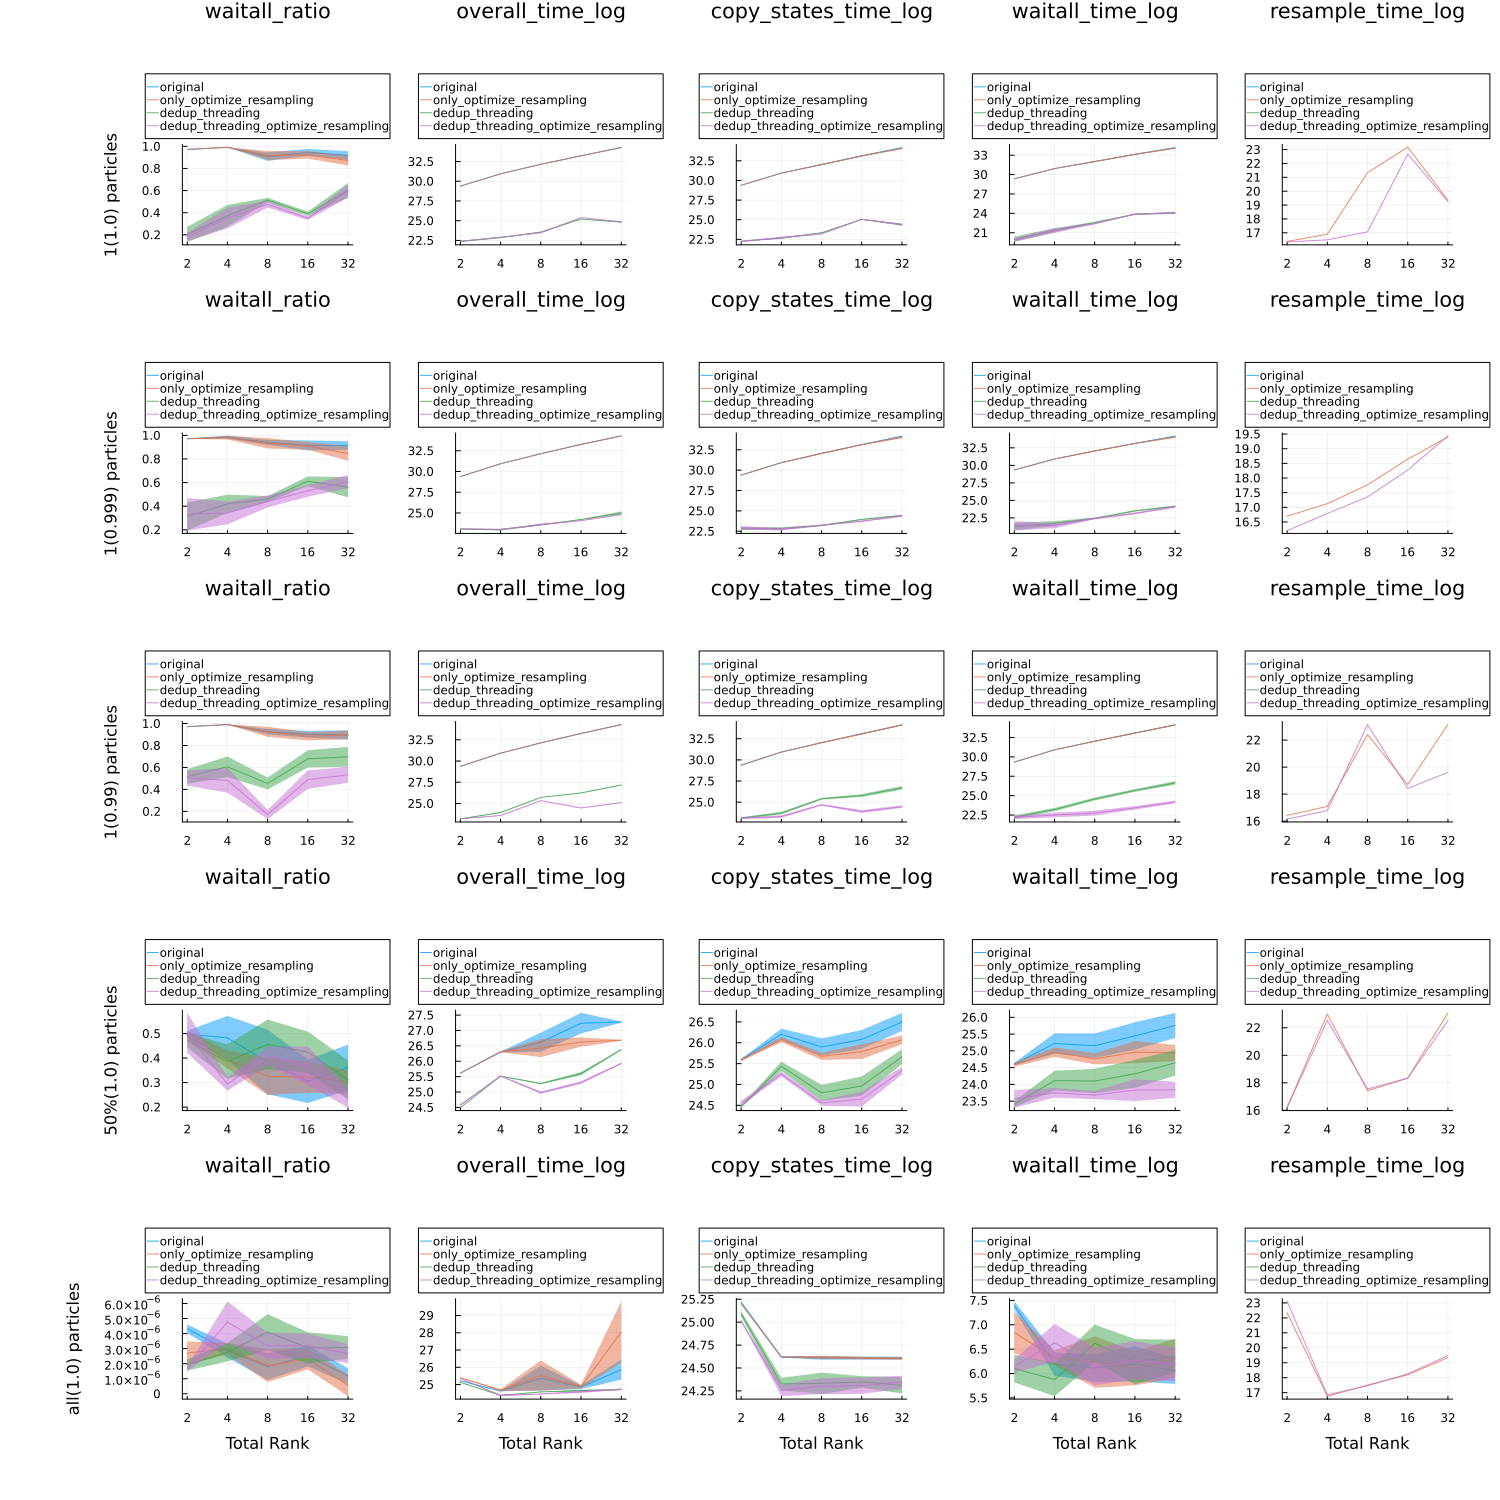

In [ ]:
root_dir = "test/output5"
_, original_100k_df = df_from_h5(root_dir, "original")
# _, dedup_100k_df = df_from_h5("only_dedup")
_, dedup_threads_100k_df = df_from_h5(root_dir, "dedup_threading")
_, op_100k_df = df_from_h5(root_dir, "only_optimize_resampling")
_, dtop_100k_df = df_from_h5(root_dir, "dedup_threading_optimize_resampling")

union_df = vcat( original_100k_df, op_100k_df, dedup_threads_100k_df, dtop_100k_df)
union_df = widen_ops(union_df)
union_df = stats(union_df)
render_stats(union_df, true)